This notebook defines a function that produces a filter spec.

In [1]:
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
def filterSpec(N,dxMin,Lf,shape="Gaussian"):
    """
    Inputs: 
    N is the number of total steps in the filter
    dxMin is the smallest grid spacing - should have same units as Lf
    Lf is the filter scale, which has different meaning depending on filter shape
    shape can currently be one of two things:
        Gaussian: The target filter has kernel ~ e^{-|x/Lf|^2}
        Taper: The target filter has target grid scale Lf. Smaller scales are zeroed out. 
               Scales larger than pi*Lf/2 are left as-is. In between is a smooth transition.
    Note that the above are properties of the *target* filter, which are not the same as the actual filter.
    
    Outputs:
    NL is the number of Laplacian steps
    isL is 1/s_i for the Laplacian steps; units of isL are the same as units of dxMin and Lf, squared
    NB is the number of Biharmonic steps
    isB is 1/|s_i|^2 for the Biharmonic steps; units of isL are the same as units of dxMin and Lf, to the 4th power
    """
    # Code only works for N>2
    if N <= 2:
        print("Code requires N>2")
        return 
    # First set up the mass matrix for the Galerkin basis from Shen (SISC95)
    M = (np.pi/2)*(2*np.eye(N-1) - np.diag(np.ones(N-3),2) - np.diag(np.ones(N-3),-2))
    M[0,0] = 3*np.pi/2
    # The range of wavenumbers is 0<=|k|<=sqrt(2)*pi/dxMin. Nyquist here is for a 2D grid. 
    # Per the notes, define s=k^2.
    # Need to rescale to t in [-1,1]: t = (2/sMax)*s -1; s = sMax*(t+1)/2
    sMax = 2*(np.pi/dxMin)**2
    # Set up target filter
    if shape == "Gaussian":
        F = lambda t: np.exp(-(sMax*(t+1)/2)*(Lf/2)**2)
    elif shape == "Taper":
        F = interpolate.PchipInterpolator(np.array([-1,(2/sMax)*(2/Lf)**2 -1,(2/sMax)*(np.pi/Lf)**2 -1,2]),np.array([1,1,0,0]))
    else:
        print("Please input a valid shape")
        return
    # Compute inner products of Galerkin basis with target
    b = np.zeros(N-1)
    points, weights = np.polynomial.chebyshev.chebgauss(N+1)
    for i in range(N-1):
        tmp = np.zeros(N+1)
        tmp[i] = 1
        tmp[i+2] = -1
        phi = np.polynomial.chebyshev.chebval(points,tmp)
        b[i] = np.sum(weights*phi*(F(points)-((1-points)/2 + F(1)*(points+1)/2)))
    # Get polynomial coefficients in Galerkin basis
    cHat = np.linalg.solve(M,b)
    # Convert back to Chebyshev basis coefficients
    p = np.zeros(N+1)
    p[0] = cHat[0] + (1+F(1))/2
    p[1] = cHat[1] - (1-F(1))/2
    for i in range(2,N-1):
        p[i] = cHat[i] - cHat[i-2]
    p[N-1] = -cHat[N-3]
    p[N] = -cHat[N-2]
    # Now plot the target filter and the approximate filter
    x = np.linspace(-1,1,251)
    k = np.sqrt((sMax/2)*(x+1))
    ax1 = plt.subplot(1,2,1)
    plt.plot(k,F(x),k,np.polynomial.chebyshev.chebval(x,p))
    ax2 = plt.subplot(1,2,2)
    plt.plot(k,F(x)-np.polynomial.chebyshev.chebval(x,p))
    # Get roots of the polynomial
    r = np.polynomial.chebyshev.chebroots(p)
    # Separate out the real and complex roots
    NL = np.size(r[np.where(np.abs(np.imag(r)) < 1E-12)]) 
    rL = np.real(r[np.where(np.abs(np.imag(r)) < 1E-12)])
    NB = (N - NL)//2
    rB = np.unique(np.abs(r[np.where(np.abs(np.imag(r)) > 1E-12)]))
    # convert roots to 1/s_i and 1/|s_i|^2 from the notes
    isL = (2/sMax)/(rL+1) # 1/s_i
    isB = ((2/sMax)/(rB+1))**2 # 1/|s_i|^2
    return NL,isL,NB,isB

The example below uses the function to generate a Gaussian filter with 11 steps and a filter scale 5 times the grid scale. (Grid scale is arbitrarily set to 0.01 here.)
The left plot shows the Fourier transform of the target filter, along with the approximation using 11 steps.
The right plot shows the error between the target and approximate filters. The approximate filter uses 11 Laplacian steps and 0 biharmonic steps.

(11, 0)

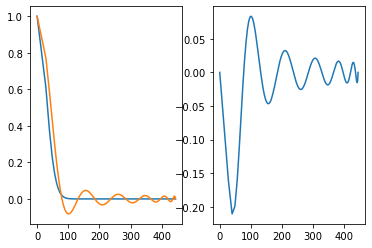

In [3]:
NL,isL,NB,isB = filterSpec(11,0.01,0.05)
NL,NB

The example below uses the function to generate a "Taper" filter (elsewhere called "sharp") with 13 steps and a filter scale 2 times the grid scale. The approximate filter uses 11 Laplacian steps and 1 biharmonic step.

(11, 1)

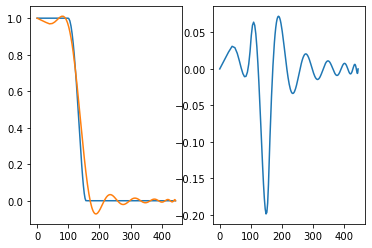

In [4]:
NL,isL,NB,isB = filterSpec(13,0.01,0.02,"Taper")
NL,NB

The cell below shows what the weights would look like for the filter defined in the cell above if we were using a 1D domain and an equispaced grid.

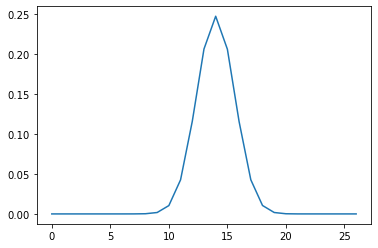

In [5]:
L = 1E4*np.array([1,-2,1])
B = 1E8*np.array([1,-4,6,-4,1])
I = np.array([0,1,0])
w = isB*B
w[3] = w[3] + 1
for i in range(11):
    w = np.convolve(I + isL[i]*L,w)
plt.plot(w)